In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.spatial.distance import jensenshannon, cosine
from scipy.stats import chi2_contingency
from scipy.spatial.distance import cdist
from scipy.linalg import norm
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import gc
from tqdm import tqdm
import sentencepiece

nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
train_all_articles = pd.read_csv('train-all-articles.csv')
train_S1_labels = pd.read_csv('train-S1-labels.csv')
train_S2_labels = pd.read_csv('train-S2-labels.csv')

# Exploratory Data Analysis

**Title:** Towards Robust Propaganda Detection: Addressing Distribution Shifts via Multi-Task Learning

**MSc Information Studies -- Data Science track**

**Name:** Alexander Hepburn

## General Summary

In [53]:
train_all_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Filename         1782 non-null   object
 1   Language         1782 non-null   object
 2   Translated_Text  1782 non-null   object
 3   Domain           1782 non-null   object
dtypes: object(4)
memory usage: 55.8+ KB


In [55]:
train_all_articles.head()

,Filename,Language,Translated_Text,Domain
0,EN_UA_104876.txt,EN,Putin honours army unit blamed for Bucha massa...,UA
1,EN_UA_011260.txt,EN,Russia has a clear plan to resolve the conflic...,UA
2,EN_UA_101067.txt,EN,"First war of TikTok era sees tragedy, humor an...",UA
3,EN_UA_300048.txt,EN,Ukraine Bombed Diesel Tanks Near A Nuclear Pla...,UA
4,EN_CC_100047.txt,EN,"Biden Has Omnibus Bill, Packed With Climate Ch...",CC


## Word Clouds

In [57]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

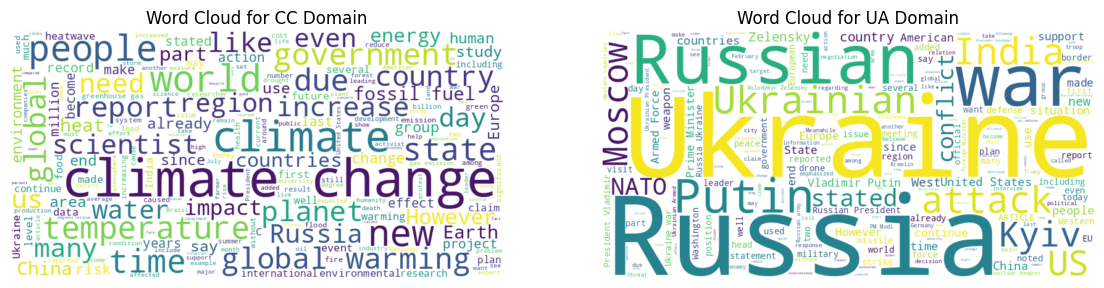

In [59]:
cc_text = " ".join(train_all_articles[train_all_articles["Domain"] == "CC"]["Translated_Text"].dropna())
ua_text = " ".join(train_all_articles[train_all_articles["Domain"] == "UA"]["Translated_Text"].dropna())

# Enhance stopwords list by adding domain-specific or project-specific terms to remove
custom_stopwords = {"said", "may", "also", "one", "would", "be", "will", "could", "year", "according", "U"}
stop_words = set(stopwords.words('english')).union(custom_stopwords)

# Generate word clouds with the updated stopwords list
wordcloud_cc = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(cc_text)
wordcloud_ua = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(ua_text)

# Display the enhanced word clouds
plt.figure(figsize=(14, 6))

# CC Domain
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_cc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for CC Domain")

# UA Domain
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ua, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for UA Domain")

plt.show()

## Distribution Shifts

In [61]:
df = train_all_articles.copy()

stop_words = set(stopwords.words('english'))

# Extract CC and UA domain texts
cc_texts = df[df["Domain"] == "CC"]["Translated_Text"].dropna().tolist()
ua_texts = df[df["Domain"] == "UA"]["Translated_Text"].dropna().tolist()

# Tokenization and Preprocessing
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    return [word for word in tokens if word.isalnum() and word not in stop_words]

cc_tokens = [preprocess(text) for text in cc_texts]
ua_tokens = [preprocess(text) for text in ua_texts]

# Flatten token lists
cc_flat = [word for sublist in cc_tokens for word in sublist]
ua_flat = [word for sublist in ua_tokens for word in sublist]


In [63]:
### 1. Word Frequency Shift (Jensen-Shannon Divergence)
def compute_js_divergence(set1, set2):
    freq1 = Counter(set1)
    freq2 = Counter(set2)

    all_words = set(freq1.keys()).union(set(freq2.keys()))

    p = np.array([freq1.get(word, 1) for word in all_words], dtype=np.float32)
    q = np.array([freq2.get(word, 1) for word in all_words], dtype=np.float32)

    p = p / p.sum()
    q = q / q.sum()

    return jensenshannon(p, q)

js_divergence = compute_js_divergence(cc_flat, ua_flat)
print(f"Jensen-Shannon Divergence (Lexical Shift): {js_divergence:.4f}")


Jensen-Shannon Divergence (Lexical Shift): 0.4067


In [65]:
### 2. TF-IDF Keyword Comparison
vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf_matrix = vectorizer.fit_transform(cc_texts + ua_texts)

cc_tfidf = tfidf_matrix[:len(cc_texts)]
ua_tfidf = tfidf_matrix[len(cc_texts):]

feature_names = vectorizer.get_feature_names_out()

cc_mean_tfidf = np.mean(cc_tfidf.toarray(), axis=0)
ua_mean_tfidf = np.mean(ua_tfidf.toarray(), axis=0)

cc_top_words = [feature_names[i] for i in cc_mean_tfidf.argsort()[-10:]]
ua_top_words = [feature_names[i] for i in ua_mean_tfidf.argsort()[-10:]]

print("Top words in CC Domain:", cc_top_words)
print("Top words in UA Domain:", ua_top_words)


Top words in CC Domain: ['temperature', 'energy', 'emissions', 'world', 'heat', 'warming', 'temperatures', 'global', 'change', 'climate']
Top words in UA Domain: ['president', 'military', 'zelensky', 'nato', 'putin', 'war', 'ukrainian', 'russian', 'russia', 'ukraine']


In [67]:
### 3. Sentence Embedding Shift (Cosine Distance)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

cc_embeddings = model.encode(cc_texts, convert_to_numpy=True)
ua_embeddings = model.encode(ua_texts, convert_to_numpy=True)

cc_mean_embedding = np.mean(cc_embeddings, axis=0)
ua_mean_embedding = np.mean(ua_embeddings, axis=0)

cosine_dist = cosine(cc_mean_embedding, ua_mean_embedding)
print(f"Cosine Distance (Sentence Embedding Shift): {cosine_dist:.4f}")


Cosine Distance (Sentence Embedding Shift): 0.6382


In [68]:
### 1️⃣ Chi-Squared Test for Lexical Frequency Shift
def compute_chi_squared(set1, set2):
    freq1 = Counter(set1)
    freq2 = Counter(set2)

    all_words = list(set(freq1.keys()).union(set(freq2.keys())))

    f1 = np.array([freq1.get(word, 1) for word in all_words])
    f2 = np.array([freq2.get(word, 1) for word in all_words])

    contingency_table = np.array([f1, f2])
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    return chi2_stat, p_value

chi2_stat, p_value = compute_chi_squared(cc_flat, ua_flat)
print(f"Chi-Squared Statistic (Lexical Shift): {chi2_stat:.4f}")
print(f"P-Value (Lexical Shift): {p_value:.4f}")

Chi-Squared Statistic (Lexical Shift): 113156.5071
P-Value (Lexical Shift): 0.0000


In [70]:
### Maximum Mean Discrepancy (MMD) for Sentence Embedding Shift
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Encode sentences into embeddings
cc_embeddings = model.encode(cc_texts, convert_to_numpy=True)
ua_embeddings = model.encode(ua_texts, convert_to_numpy=True)

# Compute MMD using Radial Basis Function (RBF) Kernel
def compute_mmd(X, Y, kernel='rbf'):
    def rbf_kernel(x, y, sigma=1.0):
        return np.exp(-norm(x - y) ** 2 / (2 * sigma ** 2))

    XX = np.mean([rbf_kernel(x, y) for x in X for y in X])
    YY = np.mean([rbf_kernel(x, y) for x in Y for y in Y])
    XY = np.mean([rbf_kernel(x, y) for x in X for y in Y])

    return XX + YY - 2 * XY

mmd_score = compute_mmd(cc_embeddings, ua_embeddings)
print(f"Maximum Mean Discrepancy (MMD) Score: {mmd_score:.4f}")


Maximum Mean Discrepancy (MMD) Score: 0.2002


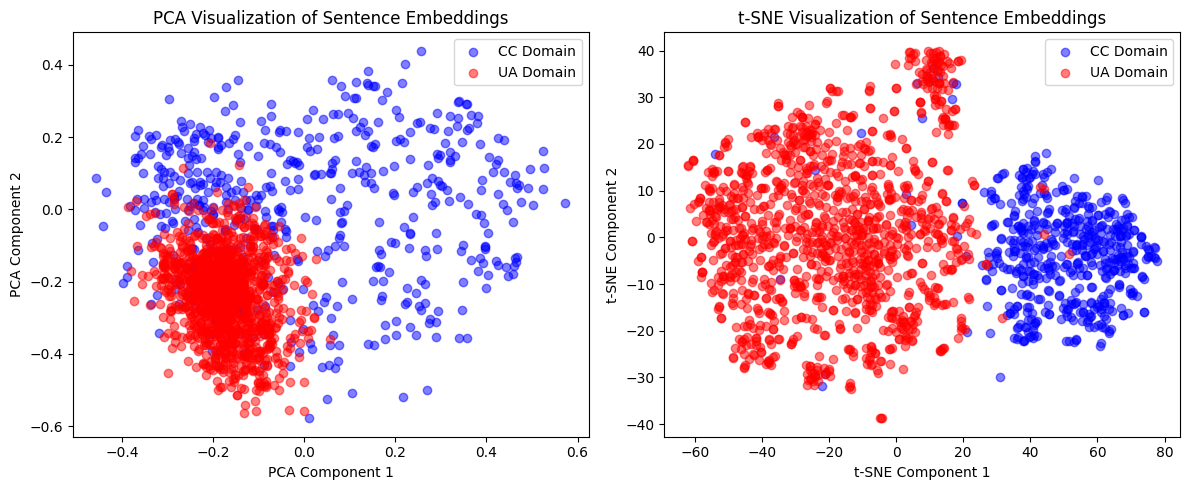

In [71]:
# Load Sentence-Transformer Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

# Encode sentences into embeddings
cc_embeddings = model.encode(cc_texts, convert_to_numpy=True)
ua_embeddings = model.encode(ua_texts, convert_to_numpy=True)

### PCA Visualization (Principal Component Analysis)
pca = PCA(n_components=2)
cc_pca = pca.fit_transform(cc_embeddings)
ua_pca = pca.transform(ua_embeddings)

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(cc_pca[:, 0], cc_pca[:, 1], color='blue', alpha=0.5, label='CC Domain')
plt.scatter(ua_pca[:, 0], ua_pca[:, 1], color='red', alpha=0.5, label='UA Domain')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Sentence Embeddings")
plt.legend()

### t-SNE Visualization (T-Distributed Stochastic Neighbor Embedding)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
all_embeddings = np.vstack((cc_embeddings, ua_embeddings))
tsne_results = tsne.fit_transform(all_embeddings)

cc_tsne = tsne_results[:len(cc_embeddings)]
ua_tsne = tsne_results[len(cc_embeddings):]

plt.subplot(1, 2, 2)
plt.scatter(cc_tsne[:, 0], cc_tsne[:, 1], color='blue', alpha=0.5, label='CC Domain')
plt.scatter(ua_tsne[:, 0], ua_tsne[:, 1], color='red', alpha=0.5, label='UA Domain')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Sentence Embeddings")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


# Entity Framing

# Narrative Classification

In [91]:
# =============================
# config
# =============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 2e-5
MODEL_PATH = "best_model.pt"


In [93]:
# =============================
# Load and Prepare Data
# =============================

df = train_all_articles.merge(train_S2_labels, on="Filename")
df = df.dropna(subset=["Translated_Text", "Narrative"])
df["Narrative"] = df["Narrative"].apply(lambda x: [n.strip() for n in str(x).split(";")])

# Multi-label binarization
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["Narrative"])
num_classes = len(mlb.classes_)


In [95]:
# =============================
# Tokenisation and Dataset (with Chunking)
# =============================
from transformers import DebertaV2Tokenizer

tokenizer = DebertaV2Tokenizer.from_pretrained(MODEL_NAME)

def chunk_text(text, tokenizer, max_len):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i + max_len] for i in range(0, len(tokens), max_len)]
    return chunks

class MultiLabelNarrativeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        words = text.split()
        chunks = [" ".join(words[i:i + self.max_len]) for i in range(0, len(words), self.max_len)]

        input_ids, attention_masks = [], []
        for chunk in chunks:
            encoded = tokenizer.encode_plus(
                chunk,
                max_length=self.max_len,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            input_ids.append(encoded["input_ids"])
            attention_masks.append(encoded["attention_mask"])

        return {
            "input_ids": torch.cat(input_ids),
            "attention_mask": torch.cat(attention_masks),
            "labels": torch.tensor(label, dtype=torch.float)
        }


In [97]:
# =============================
# Train/Validation Split
# =============================
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Translated_Text"].tolist(), y, test_size=0.2, random_state=42
)

train_dataset = MultiLabelNarrativeDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = MultiLabelNarrativeDataset(val_texts, val_labels, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # batch size 1 due to varying chunk count
val_loader = DataLoader(val_dataset, batch_size=1)


In [99]:
# =============================
# Model Definition
# =============================
class MultiLabelClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        batch_size, num_chunks, seq_len = input_ids.size()
        input_ids = input_ids.view(-1, seq_len)
        attention_mask = attention_mask.view(-1, seq_len)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        pooled = pooled.view(batch_size, num_chunks, -1).mean(1)
        return self.classifier(pooled)

model = MultiLabelClassifier(num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=EPOCHS * len(train_loader))
loss_fn = nn.BCEWithLogitsLoss()

In [101]:
# =============================
# 5. Training Loop with Early Stopping
# =============================
best_val_loss = float("inf")
early_stop_counter = 0
patience = 2

print("\n Training commences...\n")
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].squeeze(0).to(device)
        attention_mask = batch["attention_mask"].squeeze(0).to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].squeeze(0).to(device)
            attention_mask = batch["attention_mask"].squeeze(0).to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print("Best model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break


 Training commences...

100%|██████████| 1531/1531 [05:34<00:00,  4.58it/s]
Epoch 1/5 | Train Loss: 0.2412 | Val Loss: 0.2026
Best model saved.
100%|██████████| 1531/1531 [05:34<00:00,  4.57it/s]
Epoch 2/5 | Train Loss: 0.1997 | Val Loss: 0.1798
Best model saved.
100%|██████████| 1531/1531 [05:34<00:00,  4.57it/s]
Epoch 3/5 | Train Loss: 0.1780 | Val Loss: 0.1683
Best model saved.
100%|██████████| 1531/1531 [05:34<00:00,  4.57it/s]
Epoch 4/5 | Train Loss: 0.1605 | Val Loss: 0.1646
Best model saved.
100%|██████████| 1531/1531 [05:34<00:00,  4.58it/s]
Epoch 5/5 | Train Loss: 0.1446 | Val Loss: 0.1582
Best model saved.


In [104]:

# =============================
# 6. Evaluation
# =============================
def get_predictions_and_labels(dataloader, model, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].squeeze(0).to(device)
            attention_mask = batch["attention_mask"].squeeze(0).to(device)
            labels = batch["labels"].cpu().numpy()

            outputs = model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)

model.load_state_dict(torch.load(MODEL_PATH))
y_pred, y_true = get_predictions_and_labels(val_loader, model)

print("\n Evaluation Metrics on Validation Set:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score (Micro):  {f1_score(y_true, y_pred, average='micro'):.4f}")
print(f"F1 Score (Macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='micro'):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred, average='micro'):.4f}")

print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))




 Evaluation Metrics on Validation Set:
Accuracy:  0.3342
F1 Score (Micro):  0.5343
F1 Score (Macro):  0.2645
Precision: 0.7385
Recall:    0.4186

 Classification Report:
                                                        precision    recall  f1-score   support

                          CC: Amplifying Climate Fears       0.91      0.93      0.92        54
                      CC: Climate change is beneficial       0.00      0.00      0.00         2
              CC: Controversy about green technologies       0.00      0.00      0.00         7
                     CC: Criticism of climate movement       1.00      0.15      0.27        13
                     CC: Criticism of climate policies       0.42      0.36      0.38        14
         CC: Criticism of institutions and authorities       0.52      0.60      0.56        25
                        CC: Downplaying climate change       1.00      0.17      0.29         6
       CC: Green policies are geopolitical instruments      

In [3]:
# =============================
# 7. Clear Memory
# =============================
torch.cuda.empty_cache()
gc.collect()

435

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=49d39932-ba1f-4621-a036-ab99ade88496' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>